# **1. 신경망 모델 구성하기**

신경망은 데이터에 대한 연산을 수행하는 계층(layer)/모듈(module)로 구성되어 있습니다.

`torch.nn` 네임스페이스는 신경망을 구성하는데 필요한 모든 구성 요소를 제공합니다.

PyTorch의 모든 모듈은 `nn.Module`의 하위 클래스(subclass)
입니다.

신경망은 다른 모듈(계층; layer)로 구성된 모듈입니다. 이러한 중첩된 구조는 복잡한 아키텍처를 쉽게 구축하고 관리할 수 있습니다.

이어지는 장에서는 FashionMNIST 데이터셋의 이미지들을 분류하는 신경망을 구성해보겠습니다.

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 학습을 위한 장치

가능한 경우 GPU와 같은 하드웨어 가속기에서 모델을 학습하려고 합니다.
`torch.cuda` 를 사용할 수 있는지
확인하고 그렇지 않으면 CPU를 계속 사용합니다.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 클래스 정의하기

신경망 모델을 ``nn.Module`` 의 하위클래스로 정의하고, ``__init__`` 에서 신경망 계층들을 초기화합니다.

``nn.Module`` 을 상속받은 모든 클래스는 ``forward`` 메소드에 입력 데이터에 대한 연산들을 구현합니다.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #작성해보기
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

        # Linear, ReLU, Linear, ReLU, Linear로 구성


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

``NeuralNetwork`` 의 인스턴스(instance)를 생성하고 이를 ``device`` 로 이동한 뒤,
구조(structure)를 출력합니다.

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


모델을 사용하기 위해 입력 데이터를 전달합니다.

이는 일부
`백그라운드 연산들 <https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866>`_ 과 함께
모델의 ``forward`` 를 실행합니다. ``model.forward()`` 를 직접 호출하지 마세요!

모델에 입력을 호출하면 각 분류(class)에 대한 원시(raw) 예측값이 있는 10-차원 텐서가 반환됩니다.

원시 예측값을 ``nn.Softmax`` 모듈의 인스턴스에 통과시켜 예측 확률을 얻습니다.


In [ ]:
X = torch.rand(1, 28, 28, device=device)
# 작성
logits = model(X) #1 x 10 의 데이터
pred_probab = nn.Softmax(dim = 1)(logits) #10
y_pred = pred_probab.argmax(1) #확률이 가장 높은 값

print(f"Predicted class: {y_pred}")

Predicted class: tensor([9], device='cuda:0')


## 모델 계층

FashionMNIST 모델의 계층들을 살펴보겠습니다. 이를 설명하기 위해, 28x28 크기의 이미지 3개로 구성된
미니배치를 가져와, 신경망을 통과할 때 어떤 일이 발생하는지 알아보겠습니다.

In [ ]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


`nn.Flatten` 계층을 초기화하여
각 28x28의 2D 이미지를 784 픽셀 값을 갖는 연속된 배열로 변환합니다. (dim=0의 미니배치 차원은 유지됩니다.)


In [ ]:
# 작성
flatten = nn.Flatten()
flat_image = flatten(input_image)

print(flat_image.size())

torch.Size([3, 784])


`선형 계층은 저장된 가중치(weight)와
편향(bias)을 사용하여 입력에 선형 변환(linear transformation)을 적용하는 모듈입니다.

In [ ]:
# 작성
layer1 = nn.Linear(in_features = 28*28, out_features = 20)
hidden1 = layer1(flat_image)

print(hidden1.size())

torch.Size([3, 20])


## nn.ReLU

비선형 활성화(activation)는 모델의 입력과 출력 사이에 복잡한 관계(mapping)를 만듭니다.

비선형 활성화는 선형 변환 후에 적용되어 *비선형성(nonlinearity)* 을 도입하고, 신경망이 다양한 현상을 학습할 수 있도록 돕습니다.

이 모델에서는 `nn.ReLU`를 선형 계층들 사이에 사용하지만,
모델을 만들 때는 비선형성을 가진 다른 활성화를 도입할 수도 있습니다.

In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
# 작성
hidden1 = nn.ReLU()(hidden1)

print(f"After ReLU: {hidden1}") #0이하의 값들은 모두 0으로 바뀐다

Before ReLU: tensor([[0.1291, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0017,
         0.1283, 0.0000, 0.7290, 0.0000, 0.5000, 0.0000, 0.3286, 0.2627, 0.0000,
         0.0000, 0.1311],
        [0.1381, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4843, 0.0000, 0.1085,
         0.0545, 0.0000, 0.2483, 0.0496, 0.2557, 0.1867, 0.3377, 0.0867, 0.0000,
         0.0000, 0.2617],
        [0.0315, 0.2021, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1613, 0.1170,
         0.0000, 0.0000, 0.4560, 0.0000, 0.6891, 0.1876, 0.2271, 0.0000, 0.0000,
         0.0000, 0.7750]], grad_fn=<ReluBackward0>)


After ReLU: tensor([[0.1291, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0017,
         0.1283, 0.0000, 0.7290, 0.0000, 0.5000, 0.0000, 0.3286, 0.2627, 0.0000,
         0.0000, 0.1311],
        [0.1381, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4843, 0.0000, 0.1085,
         0.0545, 0.0000, 0.2483, 0.0496, 0.2557, 0.1867, 0.3377, 0.0867, 0.0000,
         0.0000, 0.2617],
       

## nn.Sequential

`nn.Sequential`은 순서를 갖는
모듈의 컨테이너입니다.

데이터는 정의된 것과 같은 순서로 모든 모듈들을 통해 전달됩니다.

순차 컨테이너(sequential container)를 사용하여
아래의 ``seq_modules`` 와 같은 신경망을 빠르게 만들 수 있습니다.

In [ ]:
# 작성
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)

input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
print(logits.shape)

torch.Size([3, 10])


nn.Softmax

신경망의 마지막 선형 계층은 `nn.Softmax <https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html>` 모듈에 전달될
([-∞, ∞] 범위의 원시 값(raw value)인) `logits` 를 반환합니다.

logits는 모델의 각 분류(class)에 대한 예측 확률을 나타내도록
[0, 1] 범위로 비례하여 조정(scale)됩니다.

``dim`` 매개변수는 값의 합이 1이 되는 차원을 나타냅니다.

In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
print(pred_probab)

tensor([[0.0981, 0.1151, 0.0861, 0.0954, 0.1040, 0.1197, 0.0776, 0.1031, 0.0775,
         0.1234],
        [0.0960, 0.1216, 0.0739, 0.1100, 0.0861, 0.1123, 0.0829, 0.0958, 0.0883,
         0.1331],
        [0.0960, 0.1205, 0.0844, 0.0994, 0.0880, 0.1019, 0.0912, 0.0980, 0.0995,
         0.1211]], grad_fn=<SoftmaxBackward0>)


## 모델 매개변수

신경망 내부의 많은 계층들은 *매개변수화(parameterize)* 됩니다. 즉, 학습 중에 최적화되는 가중치와 편향과 연관지어집니다.

``nn.Module`` 을 상속하면 모델 객체 내부의 모든 필드들이 자동으로 추적(track)되며, 모델의 ``parameters()`` 및
``named_parameters()`` 메소드로 모든 매개변수에 접근할 수 있게 됩니다.

이 예제에서는 각 매개변수들을 순회하며(iterate), 매개변수의 크기와 값을 출력합니다.

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0258,  0.0272, -0.0244,  ..., -0.0173, -0.0284, -0.0167],
        [ 0.0264,  0.0005,  0.0005,  ..., -0.0046,  0.0225, -0.0212]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0172, -0.0074], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0066, -0.0354,  0.0262,  ...,  0.0042,  0.0069,  0.0268],
        [-0.0130, -0.0296, -0.0279,  ...,  0.0058,  0.0121,  0.0262]],
       device='cuda:0', grad_fn=<Sl

# 2. **torch.autograd를 사용한 자동 미분**

신경망을 학습할 때 가장 자주 사용되는 알고리즘은 **역전파** 입니다.

이 알고리즘에서,
매개변수(모델 가중치)는 주어진 매개변수에 대한 손실 함수의 **변화도(gradient)** 에
따라 조정됩니다.

이러한 변화도를 계산하기 위해 PyTorch에는 ``torch.autograd`` 라고 불리는 자동 미분 엔진이
내장되어 있습니다.

이는 모든 계산 그래프에 대한 변화도의 자동 계산을 지원합니다.

입력 ``x``, 매개변수 ``w`` 와 ``b`` , 그리고 일부 손실 함수가 있는 가장 간단한 단일 계층
신경망을 가정하겠습니다.

PyTorch에서는 다음과 같이 정의할 수 있습니다:


In [ ]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
# 작성
w = torch.randn(5, 3, requires_grad = True)
b = torch.randn(3, requires_grad = True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## Tensor, Function과 연산그래프(Computational graph)
------------------------------------------------------------------------------------------

이 코드는 다음의 **연산그래프** 를 정의합니다:

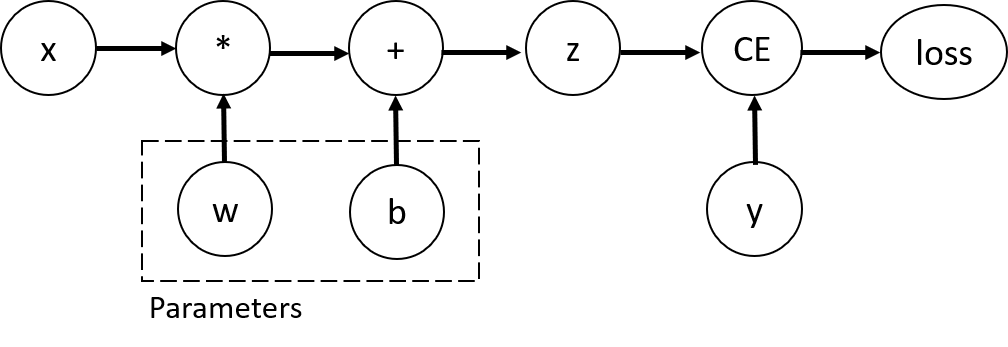..

이 신경망에서, ``w`` 와 ``b`` 는 최적화를 해야 하는 **매개변수** 입니다. 따라서
이러한 변수들에 대한 손실 함수의 변화도를 계산할 수 있어야 합니다. 이를 위해서 해당 텐서에
``requires_grad`` 속성을 설정합니다.



requires_grad의 값은 텐서를 생성할 때 설정하거나, 나중에
          x.requires_grad_(True) 메소드를 사용하여 나중에 설정할 수도 있습니다.

연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 사실 ``Function`` 클래스의 객체입니다.
이 객체는 *순전파* 방향으로 함수를 계산하는 방법과, *역방향 전파* 단계에서 도함수(derivative)를
계산하는 방법을 알고 있습니다. 역방향 전파 함수에 대한 참조(reference)는 텐서의 ``grad_fn``
속성에 저장됩니다.

In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x79f934f24760>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x79f934f275e0>


## 변화도(Gradient) 계산하기

신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를
계산해야 합니다.

즉, ``x`` 와 ``y`` 의 일부 고정값에서 $\frac{\partial loss}{\partial w}$ 와
$\frac{\partial loss}{\partial b}$ 가 필요합니다.

이러한 도함수를 계산하기 위해, ``loss.backward()`` 를 호출한 다음 ``w.grad`` 와
``b.grad`` 에서 값을 가져옵니다:

In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1987, 0.0134, 0.0326],
        [0.1987, 0.0134, 0.0326],
        [0.1987, 0.0134, 0.0326],
        [0.1987, 0.0134, 0.0326],
        [0.1987, 0.0134, 0.0326]])
tensor([0.1987, 0.0134, 0.0326])


그래프의 잎(leaf) 노드들 중 requires_grad 속성이 True로 설정된
    노드들의 grad 속성만 구할 수 있습니다. 그래프의 다른 모든 노드에서는 변화도가
    유효하지 않습니다.

## 변화도 추적 멈추기

기본적으로, ``requires_grad=True`` 인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을
지원합니다.

그러나 모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 *순전파*
연산만 필요한 경우에는, 이러한 추적이나 지원이 필요없을 수 있습니다.

연산 코드를 ``torch.no_grad()`` 블록으로 둘러싸서 연산 추적을 멈출 수 있습니다

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

# 작성
with torch.no_grad():
  z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


동일한 결과를 얻는 다른 방법은 텐서에 ``detach()`` 메소드를 사용하는 것입니다

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)
# 작성
z_det = z.detach()
print(z_det.requires_grad)

변화도 추적을 멈춰야 하는 이유들은 다음과 같습니다:
  - 신경망의 일부 매개변수를 **고정된 매개변수(frozen parameter)** 로 표시합니다. 이는 사전 학습된 신경망을 미세조정할 때 매우 일반적인 시나리오입니다.
  - 변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때
    **연산 속도가 향상됩니다.**